In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
from scipy.stats import gaussian_kde

# Low-dimensional embedding

We generate the two-dimensional opinion embedding of the preprocessed ANES dataset combined with the demographic information of respondents.

In [2]:
dfsCombined = pd.read_csv('../csvfiles/combineddata.csv')

## PCA

In [3]:
def customPCA(dfs, dim=2):
    """ Data dimensionality reduction by using PCA

    Parameters:
    dfs -- dataframe containing ANES dataset
    dim -- number of embedding dimensions
    """
    
    separator = dfs.columns.get_loc('party')
    features = dfs.iloc[:, :separator].values
    x = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(x)
    
    return principalComponents

In [4]:
points2dPCA = customPCA(dfs=dfsCombined, dim=2)

Text(0, 0.5, '$Y$')

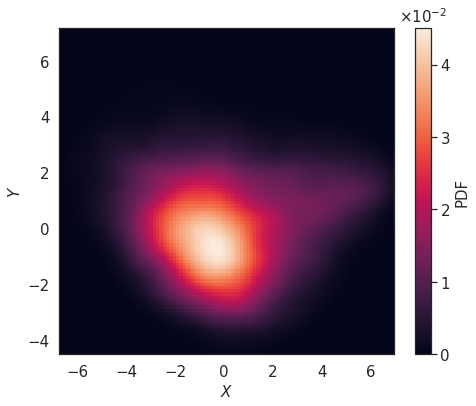

In [5]:
# Density map of PCA embedding (Supplementary Figure 13)
x = points2dPCA[:,0]
y = points2dPCA[:,1]

nbins = 100
k = gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure(figsize=(7.5,6))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
cbar = plt.colorbar(ticks=[0.00, 0.01, 0.02, 0.03, 0.04])
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$\mathregular{\times 10^{-2}}$', fontsize=15)
cbar.ax.set_ylabel('PDF', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$X$', fontsize=15)
plt.ylabel('$Y$', fontsize=15)
#plt.savefig('embedding_PCA.pdf', bbox_inches="tight")

## Isomap

In [6]:
def customISOMAP(dfs, dim, k):
    """ Data dimensionality reduction by using Isomap

    Parameters:
    dfs -- dataframe containing ANES dataset
    dim -- number of embedding dimensions
    k -- number of neighbors
    """

    iso = manifold.Isomap(
        n_neighbors=k, 
        n_components=dim, 
        n_jobs=-1,
        path_method='D',
        eigen_solver='dense'
        )
    separator = dfs.columns.get_loc('party')
    features = dfs.iloc[:, :separator]
    proj_2d = iso.fit_transform(features)
    
    return proj_2d

In [7]:
start = time.time()

points2dISOMAP = customISOMAP(dfs=dfsCombined, dim=2, k=10)

end = time.time()

print(f'Execution time: {round(end - start, 2)} s')

Execution time: 180.37 s


In [8]:
points2d = pd.DataFrame(points2dISOMAP)
points2d.to_csv('../csvfiles/embeddingISOMAP.csv', index=False)

Text(0, 0.5, '$Y$')

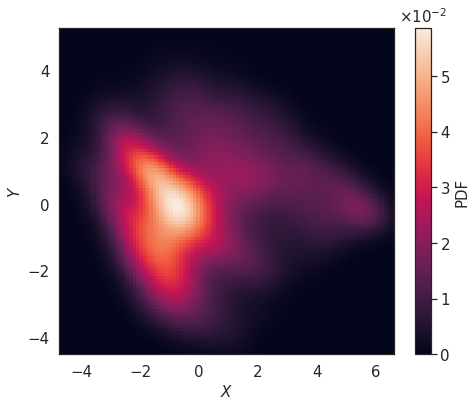

In [9]:
# Density map of Isomap embedding (Figure 1)
x = points2dISOMAP[:,0]
y = points2dISOMAP[:,1]

nbins = 100
k = gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure(figsize=(7.5,6))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
cbar = plt.colorbar(ticks=[0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$\mathregular{\times 10^{-2}}$', fontsize=15)
cbar.ax.set_ylabel('PDF', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$X$', fontsize=15)
plt.ylabel('$Y$', fontsize=15)
#plt.savefig('embedding_Isomap.pdf', bbox_inches="tight")

## Classification task (cross-validation)

We try to predict the political leaning of respondents (Republican or Democratic) by using logistic regression.

In [10]:
# ORIGINAL DATA

# Drop DK and Independents
separator = dfsCombined.columns.get_loc('party')
features = dfsCombined.iloc[:, :separator]
featuresTarget = features.copy()
politics = np.array(dfsCombined['party'])
target = list()
todrop = list()
for i,part in enumerate(politics):
    if part == 'Democrats':
        target.append(0)
    elif part == 'Republicans':
        target.append(1)
    else:
        todrop.append(i)
todrop = np.sort(todrop)[::-1]
featuresTarget.drop(todrop, inplace=True)

# Relabel index
index = list(featuresTarget.index.values)
relabel = {}
for j in range(len(index)):
    relabel.update({index[j]: j})
featuresTarget.rename(index=relabel, inplace=True)

In [11]:
# Evaluating cross-validation
LogReg = LogisticRegression(random_state=0)
scores = cross_val_score(LogReg, featuresTarget, target, cv=10)
print("Accuracy: %0.3f    Std: %0.3f" % (scores.mean(), scores.std()))

Accuracy: 0.761    Std: 0.058


In [12]:
# PCA EMBEDDING

# Drop DK and Independents
featuresTarget = points2dPCA.copy()
for index in todrop:
    featuresTarget = np.delete(featuresTarget, index, 0)

# Evaluating cross-validation
LogReg = LogisticRegression(random_state=0)
scores = cross_val_score(LogReg, featuresTarget, target, cv=10)
print("Accuracy: %0.3f    Std: %0.3f" % (scores.mean(), scores.std()))

Accuracy: 0.756    Std: 0.055


In [13]:
# ISOMAP EMBEDDING

# Drop DK and Independents
featuresTarget = points2dISOMAP.copy()
for index in todrop:
    featuresTarget = np.delete(featuresTarget, index, 0)

# Evaluating cross-validation
LogReg = LogisticRegression(random_state=0)
scores = cross_val_score(LogReg, featuresTarget, target, cv=10)
print("Accuracy: %0.3f    Std: %0.3f" % (scores.mean(), scores.std()))

Accuracy: 0.753    Std: 0.058
